# Smart tracking proof of concept
Create an artificial dataset of physical modes and harmoniocs based on a month of real data wit multiple operational states (NOV 2023)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

In [116]:
loc = 'nw2'
turbine = 'c02'

# GET THE DATA
package_folder = os.path.dirname(os.path.dirname(os.getcwd()))
data_folder = os.path.join(package_folder, 'data')
SS2_dbscan = pd.read_parquet(os.path.join(data_folder, 'interim',loc,'tracked_modes', 'dbscan_based', loc+turbine+'_SS2_mode.parquet'))
ss2_selected = pd.read_csv(os.path.join(data_folder, 'processed','nw2', turbine+'_ss2_selected_data_large.csv'))
ss2_selected.set_index('timestamp', inplace=True)
ss2_selected.index = pd.to_datetime(ss2_selected.index)
rfe_selected_data = pd.read_parquet(os.path.join(data_folder, 'interim', loc, 'rfe_selected_data', loc+turbine+'_rfe_selected_data.parquet'))

In [4]:
selected_input_data = rfe_selected_data.loc[
    datetime.datetime(2023,10,1, tzinfo=datetime.timezone.utc):datetime.datetime(2023,12,1, tzinfo=datetime.timezone.utc)
    ]

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft
# Assuming df is your DataFrame with 'time' and 'signal' columns
# Make sure 'time' is in a proper numeric format (e.g., seconds)

df = pd.DataFrame(
    {'time': rfe_selected_data.iloc[2500:3500].index, 'signal': rfe_selected_data.iloc[2500:3500].filter(regex='TAW').values[:,0]},
)

# Perform FFT
signal_fft = fft(df['signal'].values)
N = len(df['signal'])
T = (df['time'].iloc[1] - df['time'].iloc[0]).total_seconds()  # Time period

# Frequencies
frequencies = np.linspace(0.0, 1.0/(2.0*T), N//2)

# Magnitude
magnitude = 2.0/N * np.abs(signal_fft[:N//2])

# Peak frequency
peak_frequency = frequencies[2:][np.argmax(magnitude[2:])]
peak_frequency


2.1710086840347363e-05

In [6]:
1/peak_frequency

46061.53846153846

In [194]:
def generate_noisy_sinusoidal(num_samples=10000, frequency=5, noise_level=0.5, x_end = 2 * np.pi, phase=0):
    """
    Generate a noisy sinusoidal dataset.

    Parameters:
    num_samples (int): Number of samples in the dataset.
    frequency (float): Frequency of the sinusoidal signal.
    noise_level (float): Standard deviation of the Gaussian noise added to the signal.

    Returns:
    tuple: (x, y_noisy) where x is the array of x values and y_noisy is the array of noisy y values.
    """
    x = np.linspace(0, x_end, num_samples)  # X values
    y_true = np.sin(2*np.pi*frequency * x)  # True sinusoidal values
    noise = np.random.normal(0, noise_level, num_samples)  # Gaussian noise
    y_noisy = y_true + noise  # Sinusoidal data with noise
    #adapt signal to given phase
    y_noisy = np.roll(y_noisy, phase)
    return x, y_noisy

def harmonic_generation(rpm:pd.Series, noise_level=0.1, p=6):
    """
    Generate a noisy dataset that is centered around a p multiple of the rpm.
    """
    harmonic_ = rpm * p
    harmonic = harmonic_ + np.random.normal(0, noise_level, len(harmonic_))
    return harmonic

In [195]:
import numpy as np
import pandas as pd

def shift_data(data, start_shift, end_shift, max_shift):
    """
    Progressively shift the data at index start_shift until end_shift and from 
    end_shift onwards, the data should be shifted by max_shift.

    Parameters:
    data (pd.Series or np.array): The dataset to be shifted.
    start_shift (int): The index at which to start shifting the data.
    end_shift (int): The index at which the maximum shift should start being applied.
    max_shift (int): The maximum shift to apply from end_shift onwards.

    Returns:
    pd.Series or np.array: The shifted dataset.
    """
    
    # Ensure data is a Series or an array for index operations
    if not isinstance(data, (pd.Series, np.ndarray)):
        raise ValueError("Data must be a Pandas Series or NumPy array.")

    # Initialize a new array for shifted data
    shifted_data = np.zeros_like(data)

    # Ensure valid indices
    if start_shift < 0 or end_shift >= len(data) or start_shift > end_shift:
        raise ValueError("Invalid start_shift or end_shift values.")

    # Calculate the shift increment
    shift_increment = max_shift / (end_shift - start_shift) if end_shift != start_shift else max_shift

    for i in range(len(data)):
        if i < start_shift:
            # No shift before start_shift
            shifted_data[i] = data[i]
        elif start_shift <= i < end_shift:
            # Gradually increase the shift
            shift = shift_increment * (i - start_shift)
            shifted_data[i] = data[i] + shift
        else:
            # Apply max_shift
            shifted_data[i] = data[i] + max_shift

    return shifted_data if isinstance(data, np.ndarray) else pd.Series(shifted_data)


In [294]:
def shift_data(data, start_shift, end_shift, max_shift):
    """
    Progressively shift the data at index start_shift until end_shift and from 
    end_shift onwards, the data should be shifted by max_shift.

    Parameters:
    data (pd.Series or np.array): The dataset to be shifted.
    start_shift (int): The index at which to start shifting the data.
    end_shift (int): The index at which the maximum shift should start being applied.
    max_shift (int): The maximum shift to apply from end_shift onwards.

    Returns:
    pd.Series or np.array: The shifted dataset.
    """
    
    # Ensure data is a Series or an array for index operations
    if not isinstance(data, (pd.Series, np.ndarray)):
        raise ValueError("Data must be a Pandas Series or NumPy array.")

    # Initialize a new array for shifted data
    shifted_data = np.zeros_like(data)

    # Ensure valid indices
    if start_shift < 0 or end_shift >= len(data) or start_shift > end_shift:
        raise ValueError("Invalid start_shift or end_shift values.")

    # Calculate the shift increment
    shift_increment = max_shift / (end_shift - start_shift) if end_shift != start_shift else max_shift

    for i in range(len(data)):
        if i < start_shift:
            # No shift before start_shift
            shifted_data[i] = data.iloc[i] if isinstance(data, pd.Series) else data[i]
        elif start_shift <= i < end_shift:
            # Gradually increase the shift
            shift = shift_increment * (i - start_shift)
            shifted_data[i] = data.iloc[i] + shift if isinstance(data, pd.Series) else data[i] + shift
        else:
            # Apply max_shift
            shifted_data[i] = data.iloc[i] + max_shift if isinstance(data, pd.Series) else data[i] + max_shift

    return shifted_data if isinstance(data, np.ndarray) else pd.Series(shifted_data)


In [197]:
seconds, tide_sin_signal = \
    generate_noisy_sinusoidal(
        num_samples=len(rfe_selected_data),
        frequency=peak_frequency,
        noise_level=0.05,
        x_end = (rfe_selected_data.index[-1] - rfe_selected_data.index[0]).total_seconds(),
        phase=-5
        )
indices = []
for second in seconds:
    indices.append((rfe_selected_data.index[0] + datetime.timedelta(seconds=second)))
physical_mode = pd.DataFrame(
    {
        'freq':np.mean(ss2_selected['mean_frequency']) - 0.05*tide_sin_signal/np.max(tide_sin_signal)
    }, index=indices
)
physical_mode_shifted = \
    pd.DataFrame({
        'freq': shift_data(physical_mode['freq'], int(len(physical_mode['freq'])*6.5/8), int(len(physical_mode['freq'])*7.5/8), -0.05)
    }, index=physical_mode.index)

harmonic_6p = harmonic_generation(rfe_selected_data[rfe_selected_data.filter(regex='rpm').columns[0]]/60, noise_level=0.05, p=6)

In [198]:
noise_level = 0.01
tide_sin_signal_TAW = rfe_selected_data.filter(regex='TAW').values[:,0]
#min max normalize
tide_sin_signal_TAW = (tide_sin_signal_TAW - np.min(tide_sin_signal_TAW[~np.isnan(tide_sin_signal_TAW)])) / (np.max(tide_sin_signal_TAW[~np.isnan(tide_sin_signal_TAW)]) - np.min(tide_sin_signal_TAW[~np.isnan(tide_sin_signal_TAW)]))
tide_sin_signal_TAW = np.mean(ss2_selected['mean_frequency']) - tide_sin_signal_TAW * 0.1 + np.random.normal(0, noise_level, len(tide_sin_signal_TAW))

physical_mode = \
    pd.DataFrame({
        'freq': tide_sin_signal_TAW.copy()
    }, index=rfe_selected_data.index)

physical_mode_shifted = \
    pd.DataFrame({
        'freq': shift_data(physical_mode['freq'], int(len(physical_mode['freq'])*6.5/8), int(len(physical_mode['freq'])*7.5/8), -0.05)
    }, index=physical_mode.index)

harmonic_6p = harmonic_generation(rfe_selected_data[rfe_selected_data.filter(regex='rpm').columns[0]]/60, noise_level=0.05, p=6)

In [416]:
#Import the SS2 model

import pickle
models_folder = os.path.join(package_folder, 'models', loc)
model_path = os.path.join(models_folder,'catboost_model_large.pkl')
with open(model_path, 'rb') as file:  # Open the file in read mode ('rb')
    regr_model = pickle.load(file)

selected_columns = [
        'mean_NW2_C02_rpm',
        'mean_NW2_C02_pitch', 
        'mean_NW2_C02_power',
        'mean_NW2_C02_windspeed',
        'sin_mean_NW2_C02_yaw', 'cos_mean_NW2_C02_yaw',
        'sin_mean_NW2_C02_winddirection', 'cos_mean_NW2_C02_winddirection',
        'mvbc_WandelaarBuoy_Wave_height',
        #'mvbc_WandelaarBuoy_Average_wave_period',
        'mvbc_WandelaarMeasuringpile_Tide_TAW',
        #'mvbc_WandelaarMeasuringpile_Air_pressure',
        #'mvbc_WandelaarMeasuringpile_Air_temperature'
       ]
from src.data.preprocessing import sin_cos_angle_inputs
selected_input_data_preprocessed = sin_cos_angle_inputs(rfe_selected_data.copy())[selected_columns]
#Predict the SS2 mode
ss2_predicted = pd.Series(
    regr_model.predict(selected_input_data_preprocessed)[:,0],
    index=rfe_selected_data.index
    )
from sklearn.linear_model import LinearRegression
lin_regr = LinearRegression()
X_lin_regr = selected_input_data_preprocessed.loc[ss2_selected['mean_frequency'].index]
X_lin_regr.dropna(inplace=True)
common_indices_lin = ss2_selected.index.intersection(X_lin_regr.index)
y_lin_regr = ss2_selected['mean_frequency'].loc[common_indices_lin]
X_lin_regr = X_lin_regr.loc[common_indices_lin]                  
lin_regr.fit(X_lin_regr, y_lin_regr)
ss2_predicted_lin_regr = pd.Series(
    lin_regr.predict(selected_input_data_preprocessed.dropna()),
    index=selected_input_data_preprocessed.dropna().index
    )
physical_mode = pd.DataFrame({
        'freq': ss2_predicted_lin_regr.copy()
    }, index=ss2_predicted_lin_regr.index)

physical_mode_shifted = \
    pd.DataFrame({
        'freq': shift_data(physical_mode['freq'], int(len(physical_mode['freq'])*6.5/8), int(len(physical_mode['freq'])*7.5/8), -0.05)
    })
physical_mode_shifted.set_index(physical_mode.index, inplace=True)

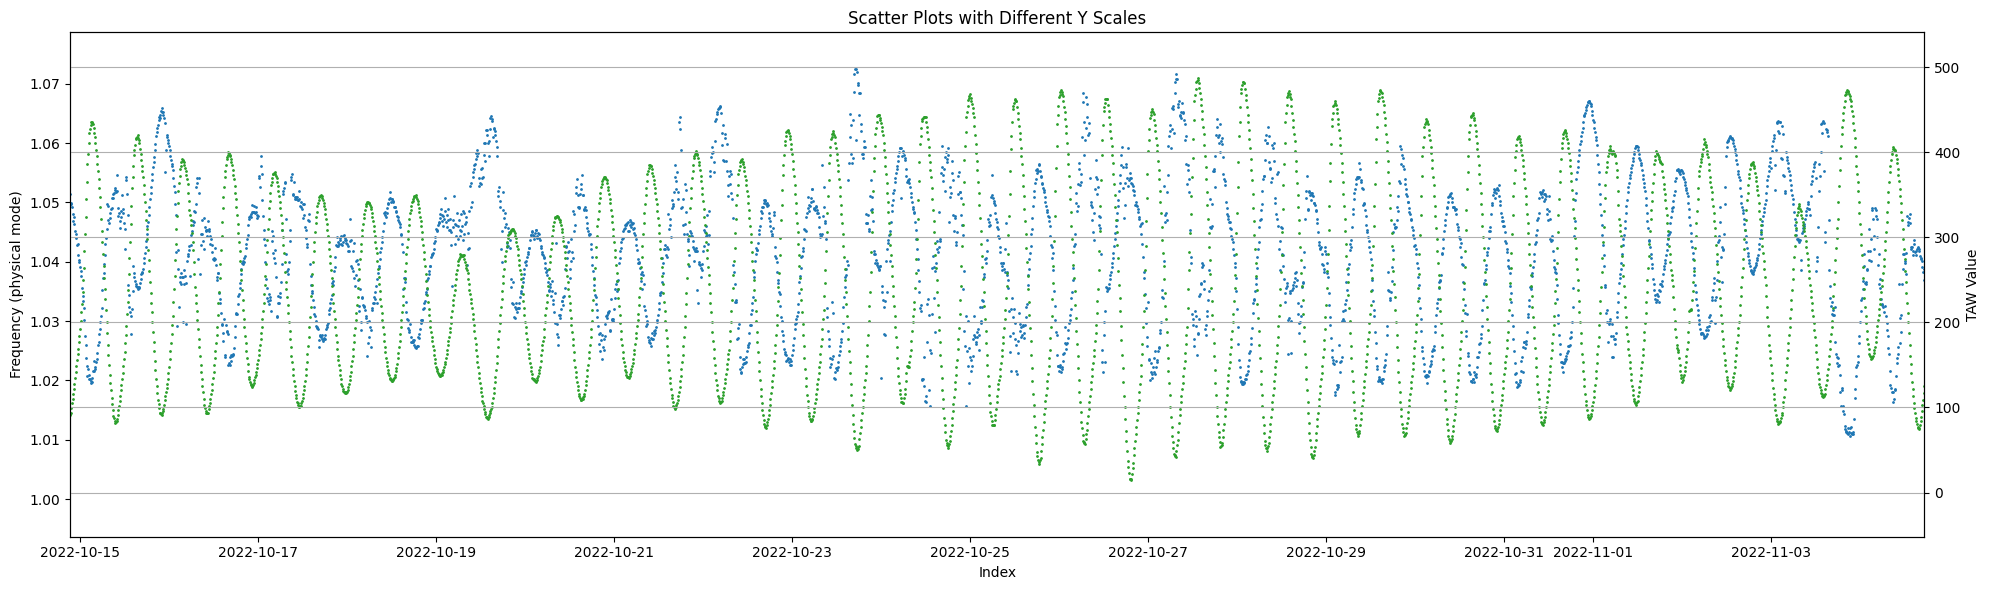

In [417]:
import matplotlib.pyplot as plt

# Assuming physical_mode and rfe_selected_data are your DataFrames

fig, ax1 = plt.subplots(figsize=(20, 6))

# Scatter plot for physical_mode
ax1.scatter(physical_mode.index, physical_mode['freq'], label='physical mode', s=1)
ax1.set_xlabel('Index')
ax1.set_ylabel('Frequency (physical mode)')
ax1.tick_params(axis='y')
#ax1.scatter(SS2_dbscan.index, SS2_dbscan['mean_frequency'], label='SS2', s=1, color='tab:orange')
#ax1.scatter(ss2_predicted.index, ss2_predicted, label='SS2 predicted', s=1, color='tab:red')
#ax1.scatter(ss2_predicted_lin_regr.index, ss2_predicted_lin_regr, label='SS2 predicted lin regr', s=1, color='tab:purple')

# Create a twin axis sharing the same x-axis
ax2 = ax1.twinx()

# Scatter plot for rfe_selected_data
ax2.scatter(rfe_selected_data.index, rfe_selected_data.filter(regex='TAW').iloc[:, 0],s=1,c='tab:green')  # Assuming you want the first column that matches the regex
ax2.set_ylabel('TAW Value')
ax2.tick_params(axis='y')

# Optionally, add a title and show the plot
plt.title('Scatter Plots with Different Y Scales')
fig.tight_layout()
plt.grid()
plt.xlim(rfe_selected_data.index[2000], rfe_selected_data.index[5000])
plt.show()


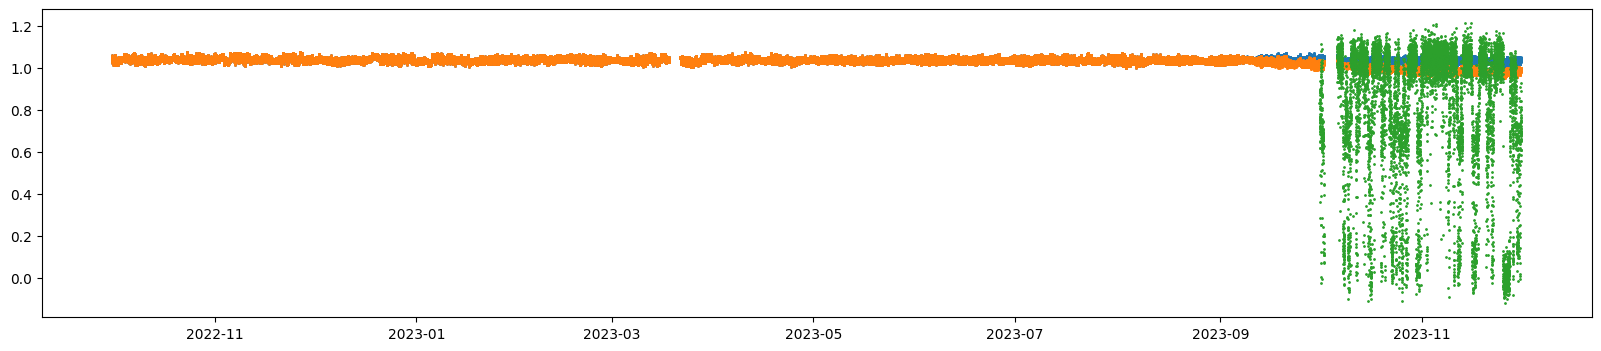

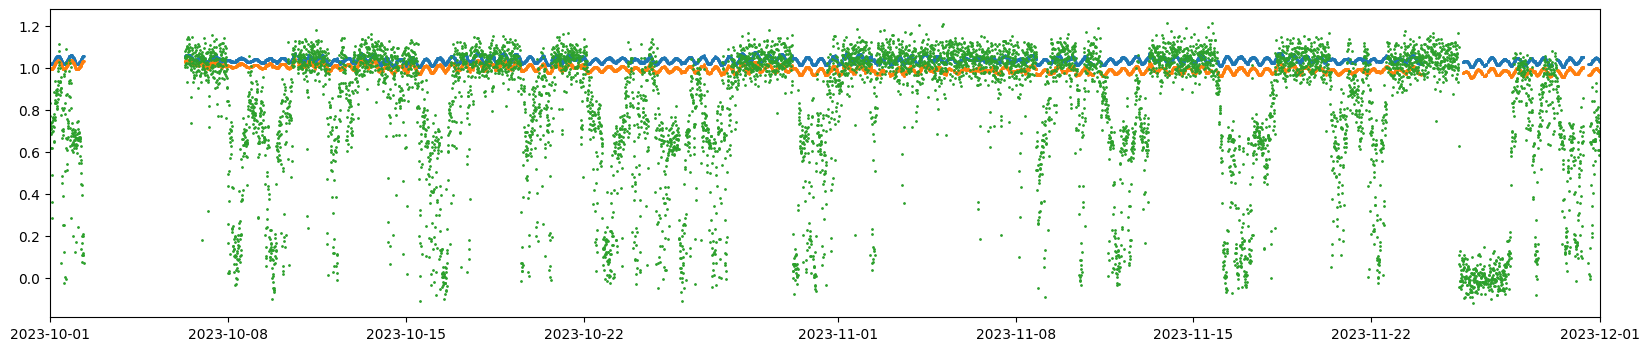

In [418]:
plt.figure(figsize=(20, 4))
plt.scatter(physical_mode.index, physical_mode, s=1)
plt.scatter(physical_mode.index, physical_mode_shifted, s=1)
plt.scatter(harmonic_6p.index, harmonic_6p, s=1)
plt.show()
plt.figure(figsize=(20, 4))
plt.scatter(physical_mode.index, physical_mode, s=1)
plt.scatter(physical_mode.index, physical_mode_shifted, s=1)
plt.scatter(harmonic_6p.index, harmonic_6p, s=1)
plt.xlim(datetime.datetime(2023,10,1, tzinfo=datetime.timezone.utc), datetime.datetime(2023,12,1, tzinfo=datetime.timezone.utc))
plt.show()

In [419]:
selected_columns = [
        'mean_NW2_C02_rpm',
        'mean_NW2_C02_pitch', 
        'mean_NW2_C02_power',
        'mean_NW2_C02_windspeed',
        'sin_mean_NW2_C02_yaw', 'cos_mean_NW2_C02_yaw',
        'sin_mean_NW2_C02_winddirection', 'cos_mean_NW2_C02_winddirection',
        'mvbc_WandelaarBuoy_Wave_height',
        'mvbc_WandelaarBuoy_Average_wave_period',
        'mvbc_WandelaarMeasuringpile_Tide_TAW',
        #'mvbc_WandelaarMeasuringpile_Air_pressure',
        'mvbc_WandelaarMeasuringpile_Air_temperature'
       ]

In [420]:
from src.data.preprocessing import sin_cos_angle_inputs
from sklearn.model_selection import train_test_split
X_ = rfe_selected_data.copy()
X = sin_cos_angle_inputs(X_)
X = X[selected_columns]
y = physical_mode['freq'].copy()
common_indices = X.dropna().index.intersection(y.index)
X = X.loc[common_indices]
y = y.loc[common_indices]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

rpm_condition = (X_train.filter(regex='rpm') < 8).any(axis=1)
X_train_filtered = X_train[rpm_condition]
X_train_filtered
X_train = X_train_filtered
y_train = y_train.loc[X_train.index]

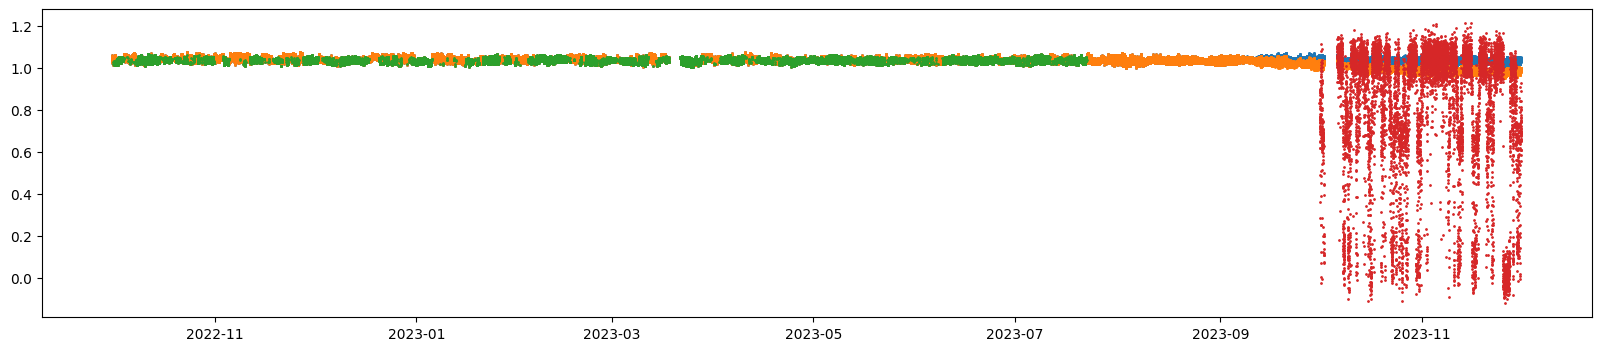

In [421]:
plt.figure(figsize=(20, 4))
plt.scatter(physical_mode.index, physical_mode, s=1)
plt.scatter(physical_mode.index, physical_mode_shifted, s=1)
plt.scatter(y_train.index, y_train, s=1)
plt.scatter(harmonic_6p.index, harmonic_6p, s=1)
plt.show()

In [422]:
from src.data.preprocessing import sin_cos_angle_inputs
from sklearn.model_selection import train_test_split
X_ = rfe_selected_data.copy()
X = sin_cos_angle_inputs(X_)
X = X[selected_columns]
y = physical_mode['freq'].copy()
common_indices = X.dropna().index.intersection(ss2_selected.index)
common_indices = common_indices.intersection(y.index)
y_train = y.loc[common_indices]
X_train = X.loc[common_indices]
y_train = y_train.loc[common_indices]

In [423]:
from src.data.preprocessing import sin_cos_angle_inputs
from sklearn.model_selection import train_test_split
X_ = rfe_selected_data.copy()
X = sin_cos_angle_inputs(X_)
X = X[selected_columns]
y = ss2_predicted_lin_regr.copy()
common_indices_Xy = X.index.intersection(y.index)
X = X.loc[common_indices_Xy]
y = y.loc[common_indices_Xy]

common_indices = X.dropna().index.intersection(ss2_selected.index)
common_indices = common_indices.intersection(y.index)
y_train = y.loc[common_indices]
X_train = X.loc[common_indices]
y_train = y_train.loc[common_indices]

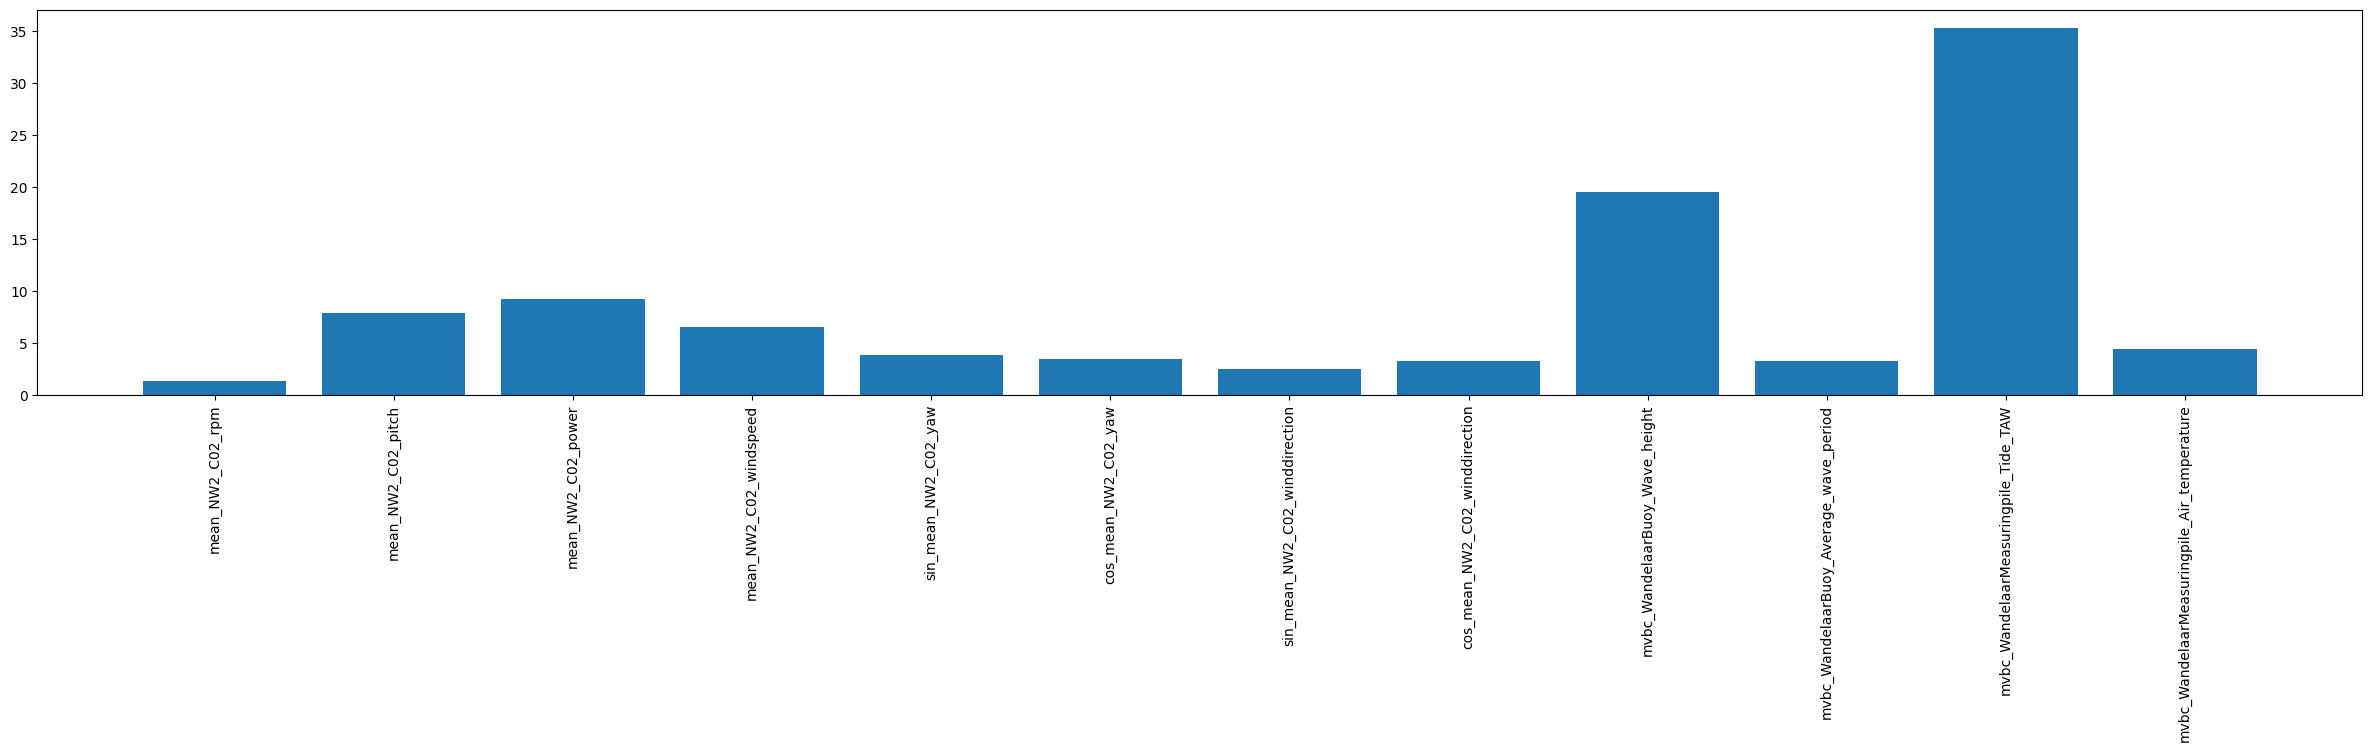

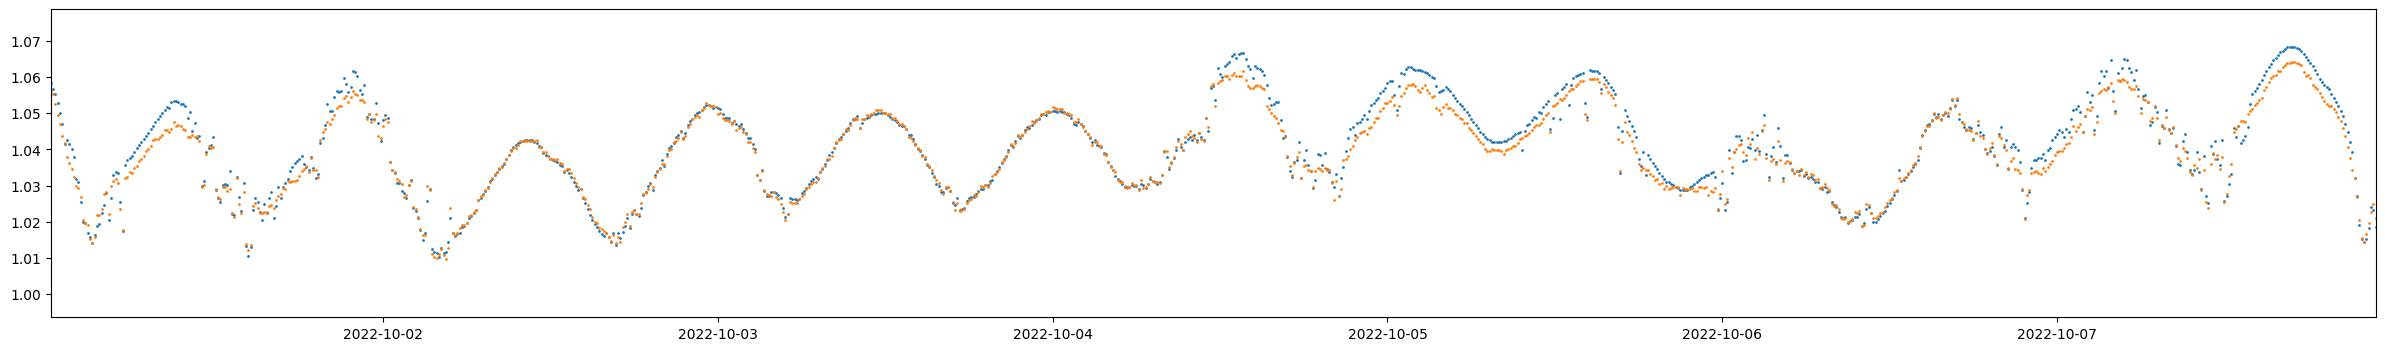

In [424]:
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression

regr_model = CatBoostRegressor(iterations=2000, depth=3, learning_rate=0.1, l2_leaf_reg=0.1, random_seed=0,posterior_sampling=True, loss_function='RMSEWithUncertainty', verbose=False)
regr_model.fit(X_train, y_train)

xgb_regr = XGBRegressor()
xgb_regr.fit(X_train, y_train)

lin_regr = LinearRegression()
lin_regr.fit(X_train, y_train)

plt.figure(figsize=(30,5))
plt.bar(regr_model.feature_names_, regr_model.feature_importances_)
plt.xticks(rotation=90)
plt.show()
plt.close()

plt.figure(figsize=(30,4))
plt.scatter(X.index, y, s=1)
plt.scatter(X.index, regr_model.predict(X)[:,0], s=1)
#plt.scatter(X.index, xgb_regr.predict(X),  s=1)
#plt.scatter(X.dropna().index, lin_regr.predict(X.dropna()),  s=1)
plt.xlim(X.index[0], X.index[1000])
plt.show()

In [439]:
import pandas as pd
predictions = regr_model.predict(X)
predictions_df = pd.DataFrame(predictions, columns=['prediction', 'spread'], index=X.index)

predicted_value = predictions[:,0]
predicted_total_uncertainty = predictions[:,1]

# Virtual ensemble predictions
virtual_ensemble_preds = regr_model.virtual_ensembles_predict(X, prediction_type='TotalUncertainty', virtual_ensembles_count=20, ntree_end=100) #, virtual_ensembles_count=100, ntree_end=200)
virtual_ensemble_preds_df = pd.DataFrame(virtual_ensemble_preds, columns=['prediction', 'knowledge uncertainty', 'data uncertainty'], index=X.index)

virtual_ensemble_preds_mean = virtual_ensemble_preds[:,0] # mean values predicted by a virtual ensemble
knowledge_uncertainty = virtual_ensemble_preds[:,1] # knowledge uncertainty predicted by a virtual ensemble
data_uncertainty = virtual_ensemble_preds[:,2] # average estimated data uncertainty

predictions_df['virtual_ensemble_mean'] = virtual_ensemble_preds_mean
predictions_df['knowledge_uncertainty'] = knowledge_uncertainty
predictions_df['data_uncertainty'] = data_uncertainty

uncertainty_ = pd.Series(knowledge_uncertainty, index=X.index).copy()
uncertainty_moving_avg = pd.Series(uncertainty_, index=X.index).rolling(6*6, center=True).mean()

uncertainty_lim = uncertainty_.loc[X_train.index].quantile(0.9)
prediction_lim = (y_train - predictions_df['prediction'].loc[X_train.dropna().index]).std()*5

# Smart tracking
from src.smart_tracking.smart_tracking import *

smart_tracked_modes = smart_tracking(
    physical_mode['freq'],
    predictions_df['prediction'],
    uncertainty_,
    uncertainty_lim,
    prediction_lim
    )

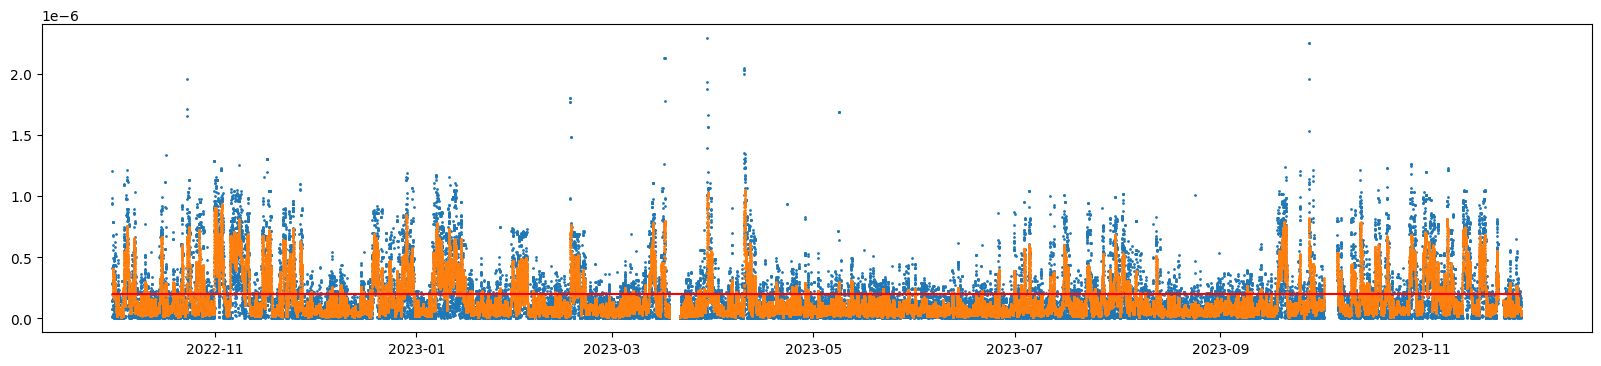

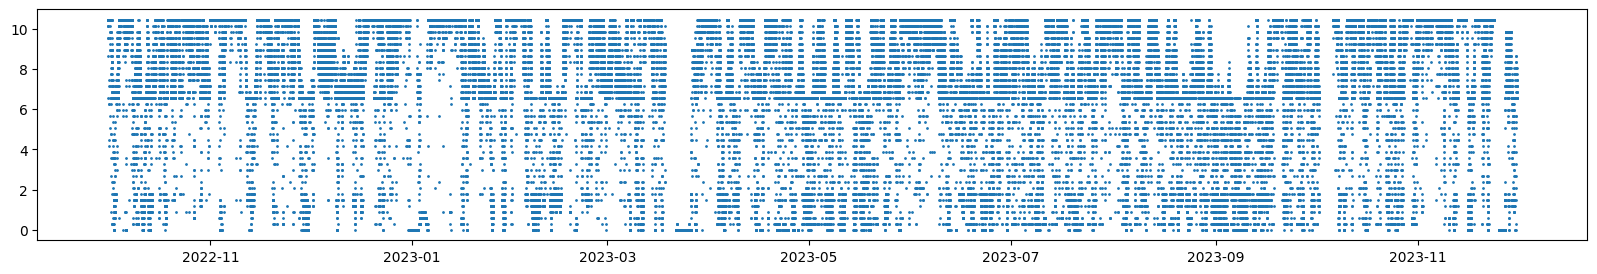

In [440]:
plt.figure(figsize=(20, 4))
plt.scatter(uncertainty_.index, uncertainty_, s=1)
plt.scatter(uncertainty_moving_avg.index, uncertainty_moving_avg, s=1)
plt.hlines(uncertainty_lim, uncertainty_moving_avg.index[0], uncertainty_moving_avg.index[-1], color='r')
plt.show()
plt.figure(figsize=(20, 3))
plt.scatter(X.index,X.filter(regex='rpm'), s=1)

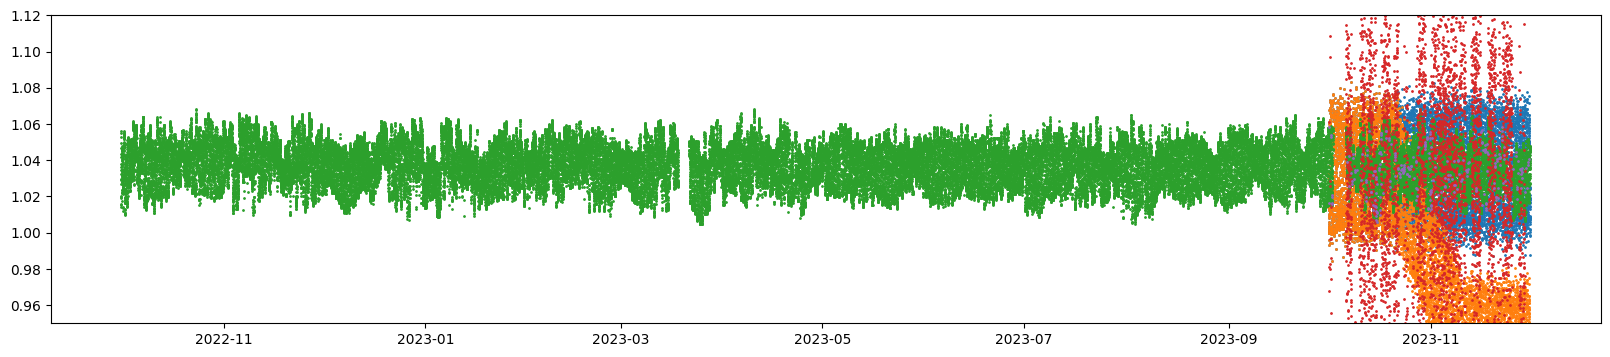

In [451]:
plt.figure(figsize=(20, 4))
plt.scatter(physical_mode.index, physical_mode['freq'], s=1)
plt.scatter(physical_mode.index, physical_mode_shifted, s=1)
plt.scatter(predictions_df.index, predictions_df['prediction'], s=1)
plt.scatter(harmonic_6p.index, harmonic_6p, s=1)
plt.scatter(smart_tracked_modes.index, smart_tracked_modes['freq'], s=1)
plt.ylim(0.95,1.12)
plt.show()

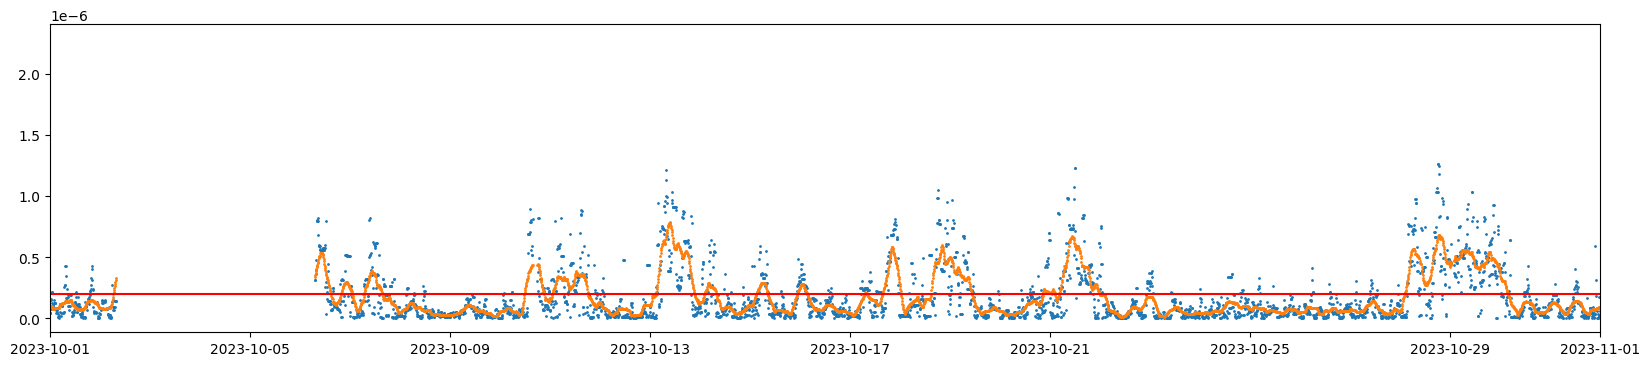

(19631.0, 19662.0)

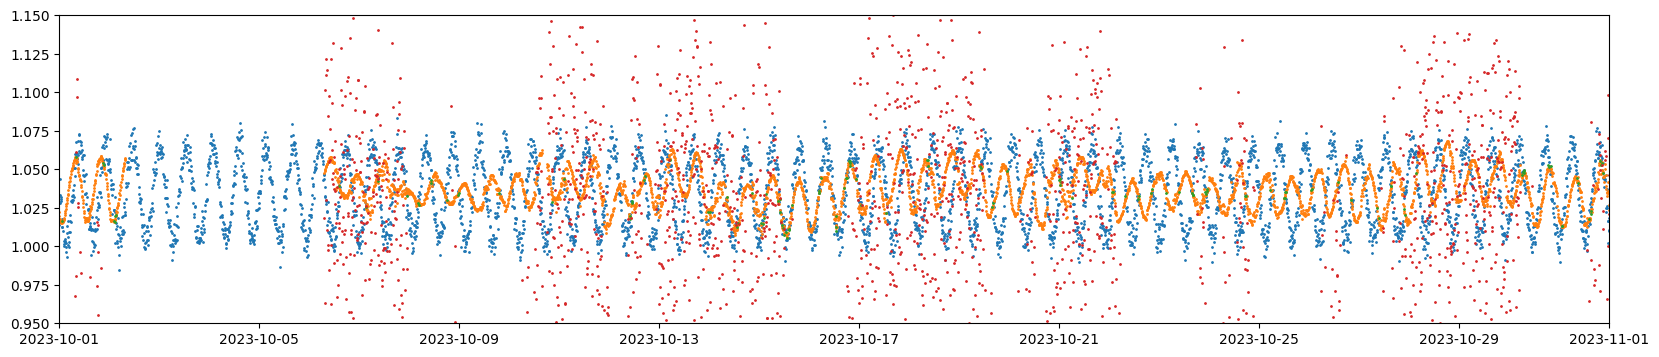

In [452]:
plt.figure(figsize=(20, 4))
plt.scatter(uncertainty_.index, uncertainty_, s=1)
plt.scatter(uncertainty_moving_avg.index, uncertainty_moving_avg, s=1)
plt.hlines(uncertainty_lim, uncertainty_moving_avg.index[0], uncertainty_moving_avg.index[-1], color='r')
plt.xlim(datetime.datetime(2023,10,1, tzinfo=datetime.timezone.utc), datetime.datetime(2023,11,1, tzinfo=datetime.timezone.utc))
plt.show()
plt.figure(figsize=(20, 4))
plt.scatter(physical_mode.index, physical_mode['freq'], s=1)
plt.scatter(predictions_df.index, predictions_df['prediction'], s=1)
plt.scatter(smart_tracked_modes.index, smart_tracked_modes['freq'], s=1)
plt.scatter(harmonic_6p.index, harmonic_6p, s=1)
plt.ylim(0.95,1.15)
plt.xlim(datetime.datetime(2023,10,1, tzinfo=datetime.timezone.utc), datetime.datetime(2023,11,1, tzinfo=datetime.timezone.utc))

In [443]:
knowledge_uncertainty

array([9.79549396e-07, 9.34995551e-07, 1.20738702e-06, ...,
       1.39668453e-07, 1.30818288e-07, 1.68926064e-07])

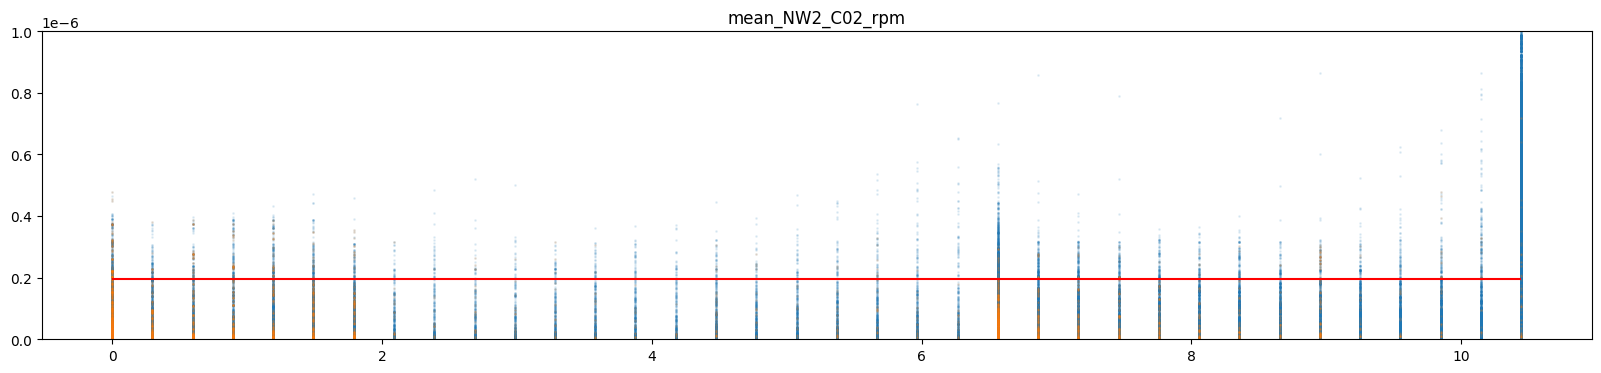

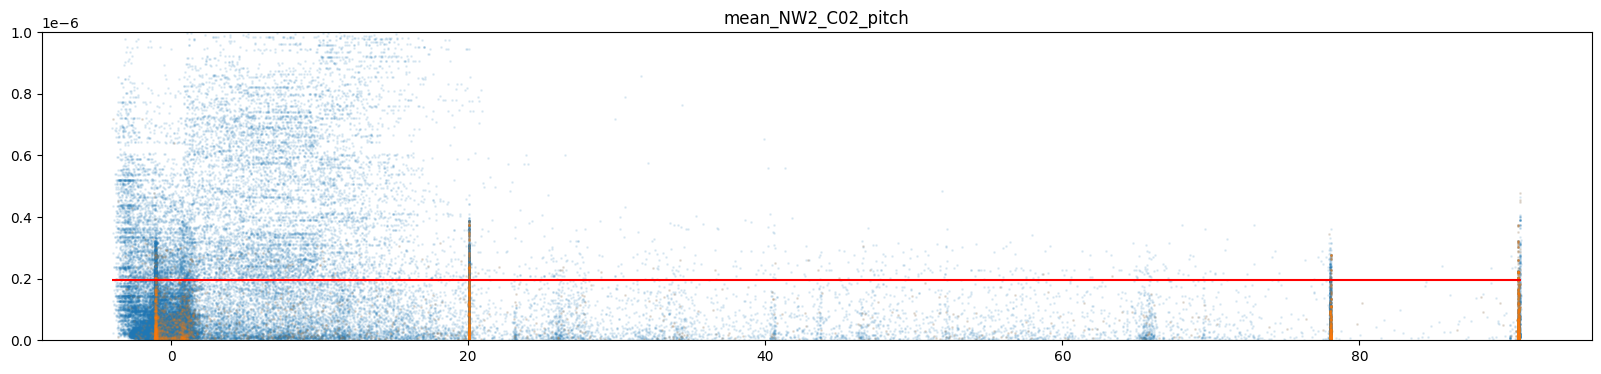

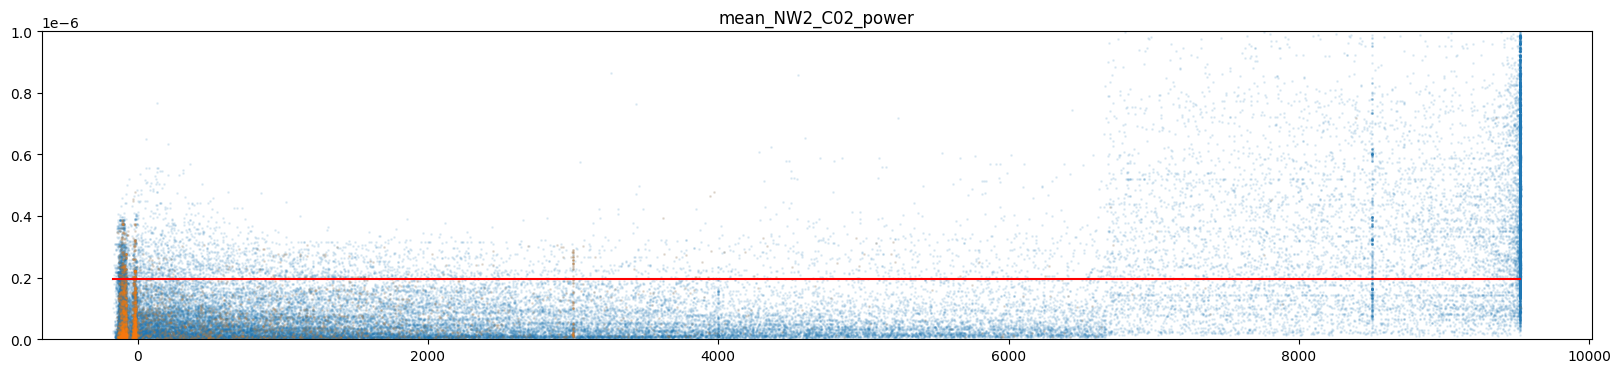

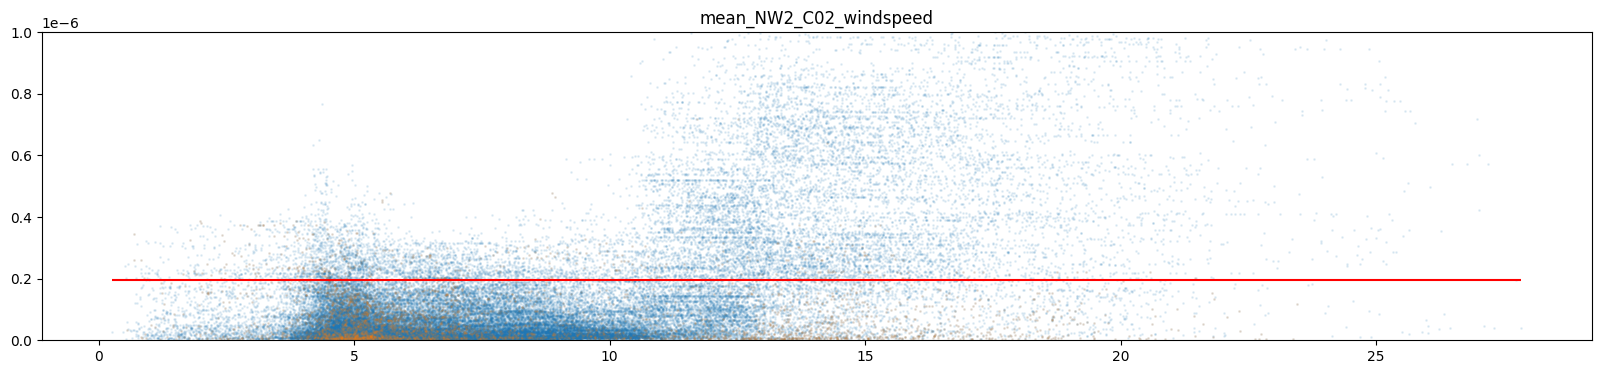

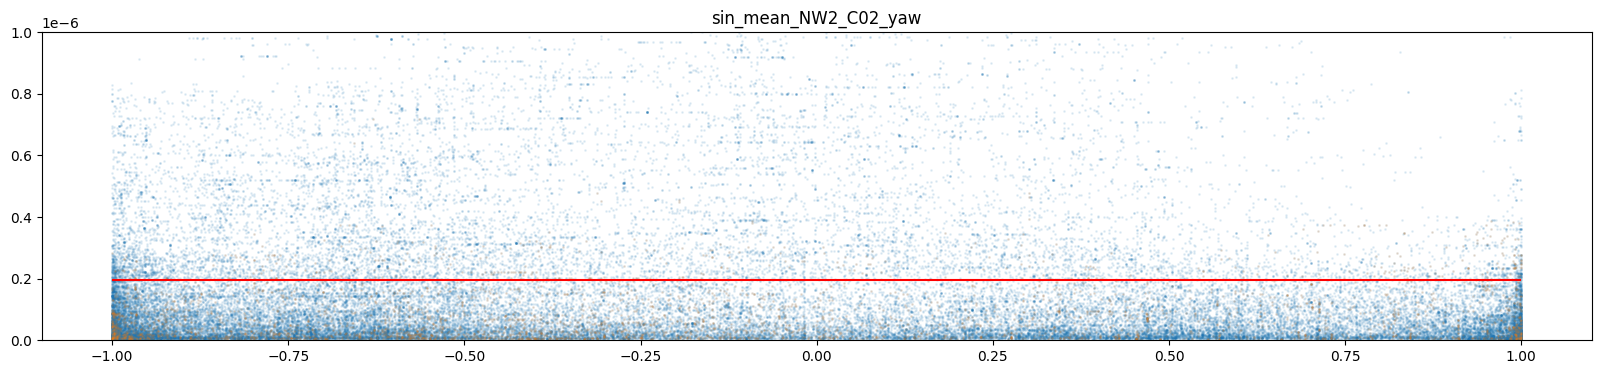

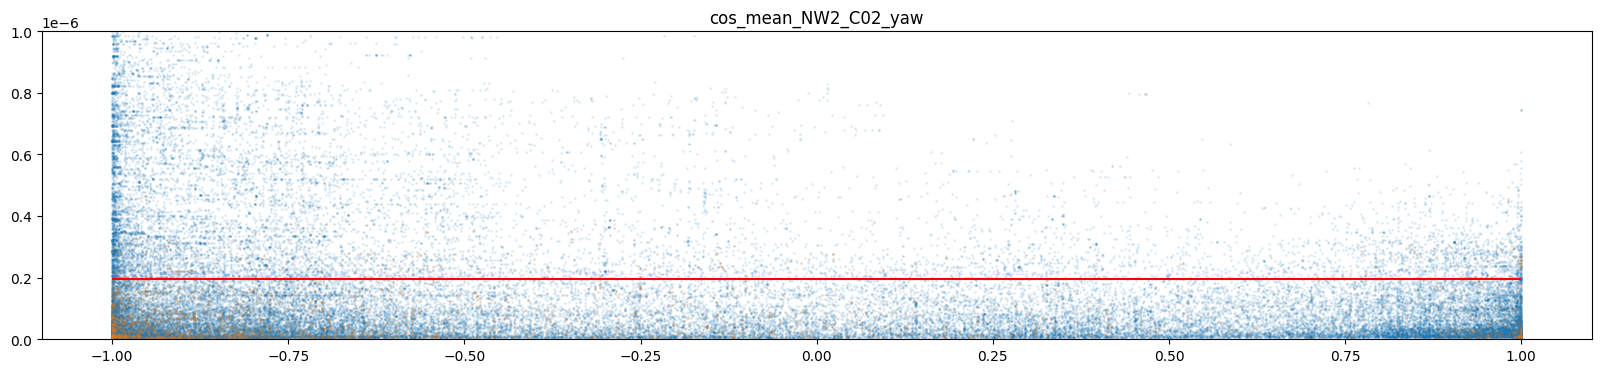

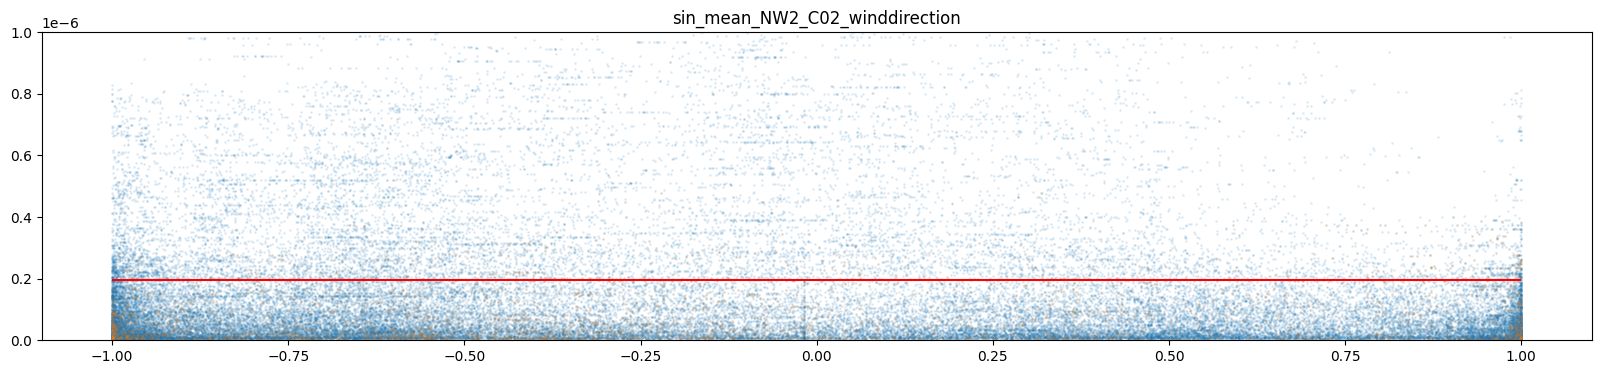

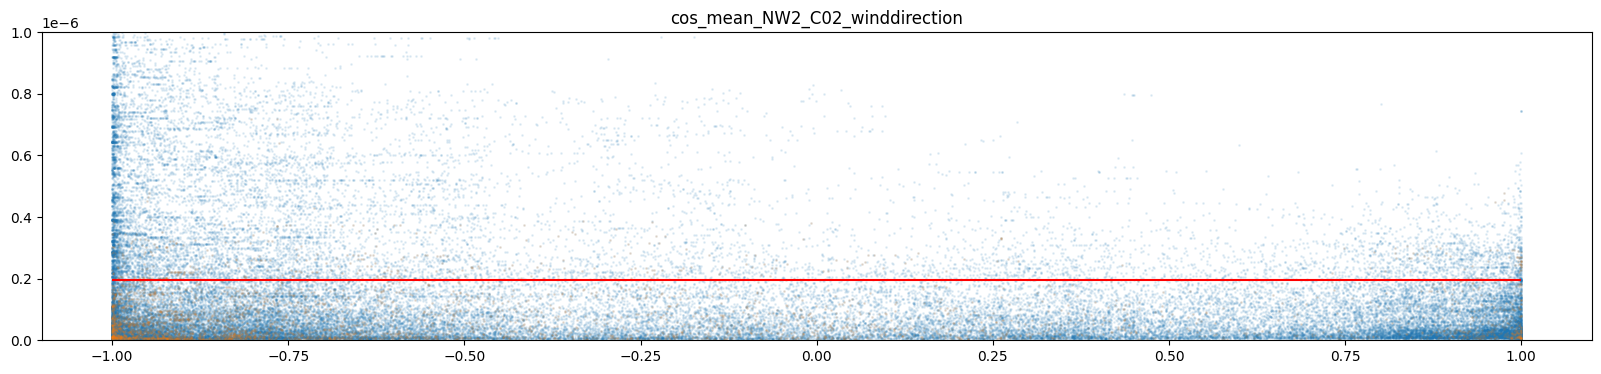

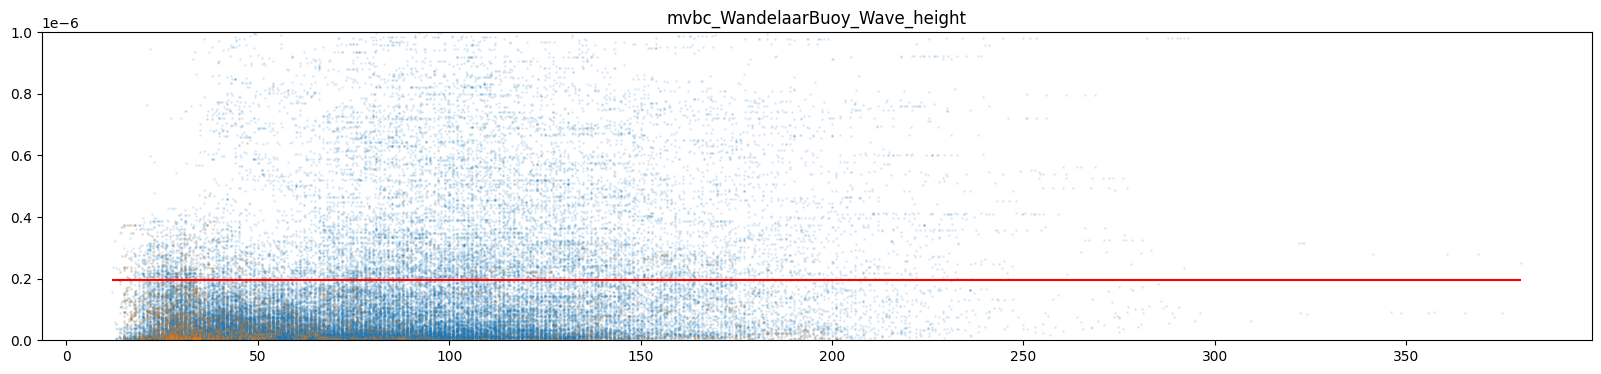

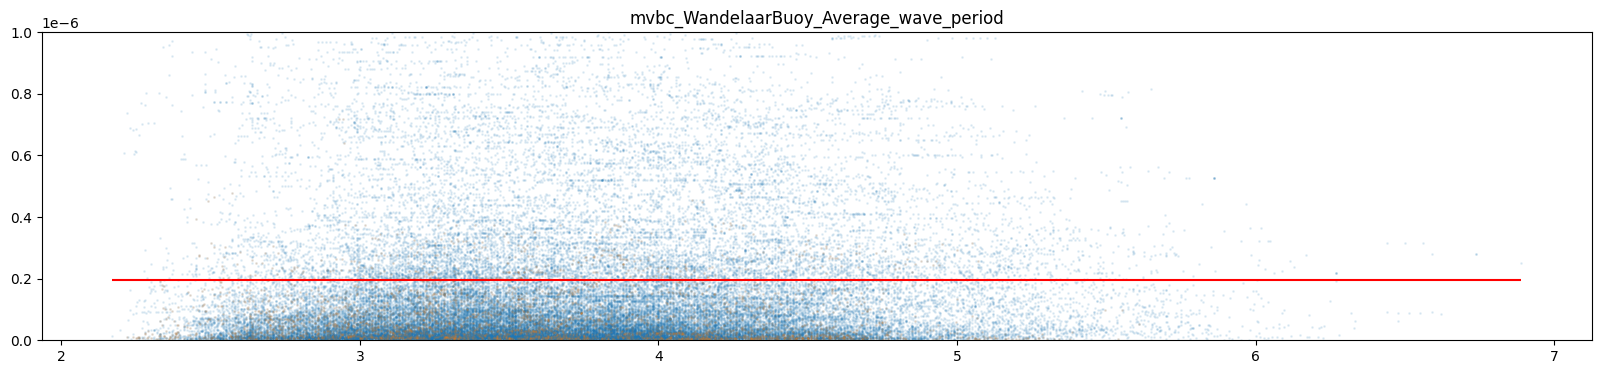

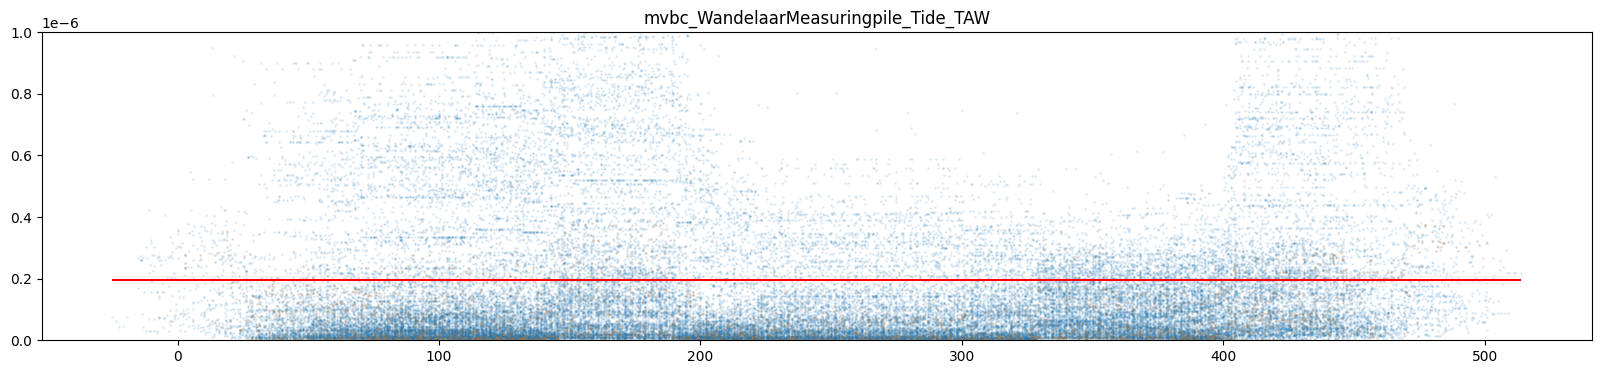

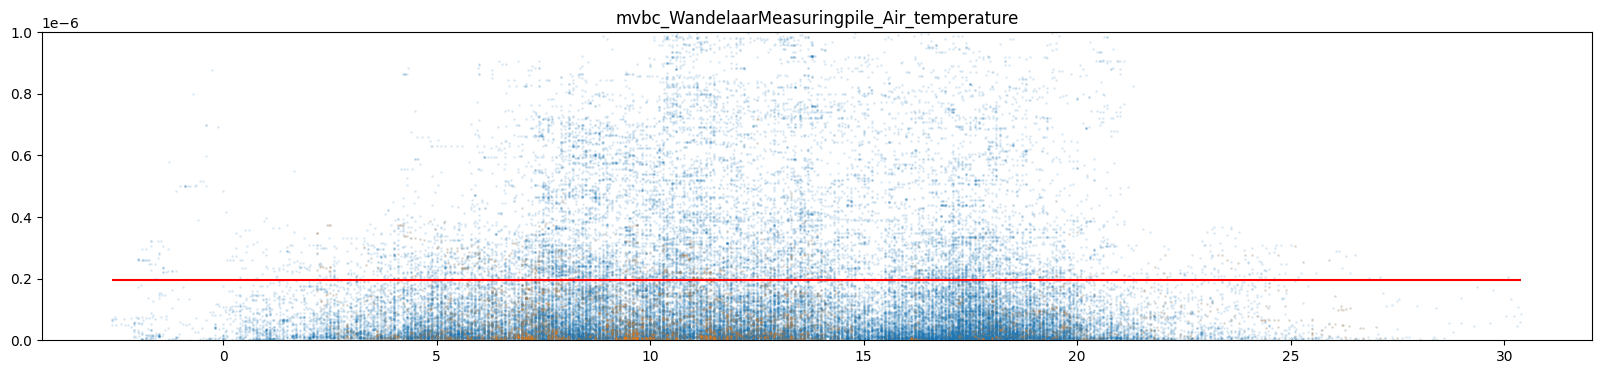

In [444]:
for col in X.columns:
    plt.figure(figsize=(20, 4))
    plt.scatter(X[col],knowledge_uncertainty, s=1, alpha=0.1)
    plt.scatter(X_train[col],predictions_df['knowledge_uncertainty'].loc[X_train.index], s=1, alpha=0.1)
    plt.hlines(uncertainty_lim, np.min(X[col]), np.max(X[col]), color='r')
    plt.ylim(0,1e-6)
    plt.title(col)
    plt.show()

In [445]:
seconds, tide_sin_signal = \
    generate_noisy_sinusoidal(
        num_samples=len(selected_input_data),
        frequency=peak_frequency,
        noise_level=0.2,
        x_end = (selected_input_data.index[-1] - selected_input_data.index[0]).total_seconds()
        )
indices = []
for second in seconds:
    indices.append((selected_input_data.index[0] + datetime.timedelta(seconds=second)))
physical_mode = pd.DataFrame(
    {
        'freq':np.mean(ss2_selected['mean_frequency']) - 0.05*tide_sin_signal/np.max(tide_sin_signal)
    }, index=indices
)

In [446]:
physical_mode_shifted = shift_data(physical_mode['freq'], int(len(physical_mode['freq'])/3), int(len(physical_mode['freq'])*2/3), -0.1)

In [447]:
harmonic_6p = harmonic_generation(selected_input_data[selected_input_data.filter(regex='rpm').columns[0]]/60, noise_level=0.05, p=6)

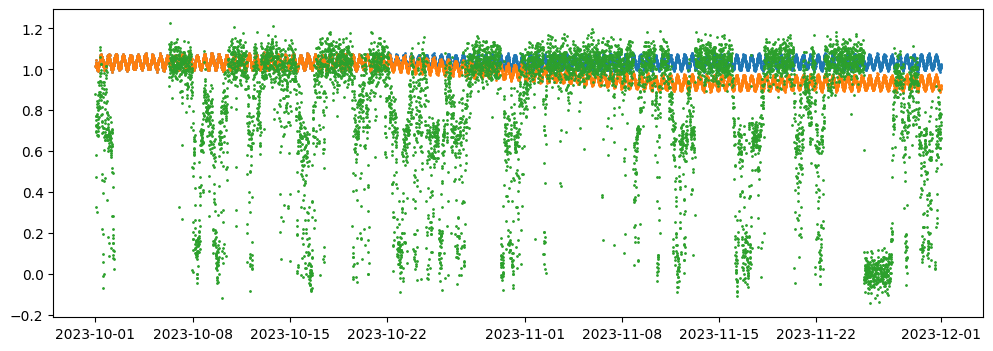

In [448]:
plt.figure(figsize=(12, 4))
plt.scatter(physical_mode.index, physical_mode, s=1)
plt.scatter(physical_mode.index, physical_mode_shifted, s=1)
plt.scatter(harmonic_6p.index, harmonic_6p, s=1)
plt.show()

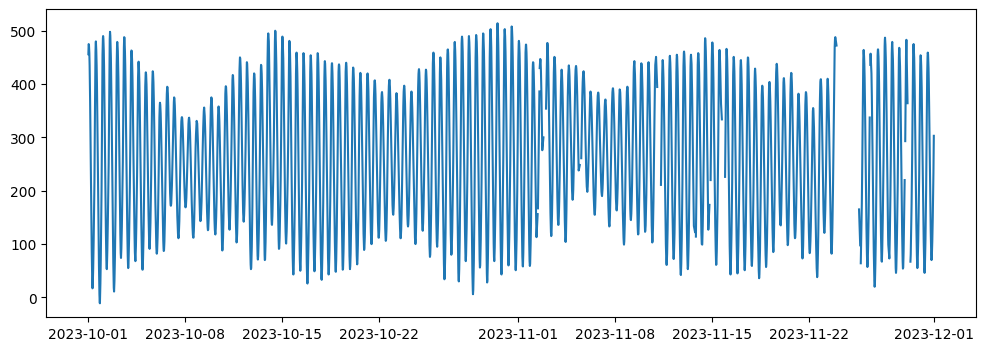

In [449]:
plt.figure(figsize=(12, 4))
plt.plot(selected_input_data.filter(regex='TAW'))

In [450]:
rfe_selected_data

mvbc_WandelaarBuoy_10%_highest_waves  \
2022-10-01 00:00:00+00:00                            173.000000   
2022-10-01 00:10:00+00:00                            173.000000   
2022-10-01 00:20:00+00:00                            173.000000   
2022-10-01 00:30:00+00:00                            173.000000   
2022-10-01 00:40:00+00:00                            178.666667   
...                                                         ...   
2023-11-30 23:20:00+00:00                            100.666667   
2023-11-30 23:30:00+00:00                            103.000000   
2023-11-30 23:40:00+00:00                            105.000000   
2023-11-30 23:50:00+00:00                            107.000000   
2023-12-01 00:00:00+00:00                            109.000000   

                           mvbc_WandelaarBuoy_Wave_height  \
2022-10-01 00:00:00+00:00                      135.000000   
2022-10-01 00:10:00+00:00                      135.333333   
2022-10-01 00:20:00+00:00                      135.666667   
2022-10-01 00:30:00+00:00                      136.000000   
2022-10-01 00:40:00+00:00                      140.333333   
...                                                   ...   
2023-11-30 23:20:00+00:00                       79.333333   
2023-11-30 23:30:00+00:00                       81.000000   
2023-11-30 23:40:00+00:00                       82.333333   
2023-11-30 23:50:00+00:00                       83.666667   
2023-12-01 00:00:00+00:00                       85.000000   

                           mvbc_WandelaarBuoy_Average_wave_period  \
2022-10-01 00:00:00+00:00                                4.270000   
2022-10-01 00:10:00+00:00                                4.243333   
2022-10-01 00:20:00+00:00                                4.216667   
2022-10-01 00:30:00+00:00                                4.190000   
2022-10-01 00:40:00+00:00                                4.163333   
...                                                           ...   
2023-11-30 23:20:00+00:00                                4.400000   
2023-11-30 23:30:00+00:00                                4.350000   
2023-11-30 23:40:00+00:00                                4.433333   
2023-11-30 23:50:00+00:00                                4.516667   
2023-12-01 00:00:00+00:00                                4.600000   

                           mvbc_WandelaarBuoy_Sea_water_temperature  \
2022-10-01 00:00:00+00:00                                       NaN   
2022-10-01 00:10:00+00:00                                       NaN   
2022-10-01 00:20:00+00:00                                       NaN   
2022-10-01 00:30:00+00:00                                       NaN   
2022-10-01 00:40:00+00:00                                       NaN   
...                                                             ...   
2023-11-30 23:20:00+00:00                                  9.000000   
2023-11-30 23:30:00+00:00                                  9.000000   
2023-11-30 23:40:00+00:00                                  9.066667   
2023-11-30 23:50:00+00:00                                  9.133333   
2023-12-01 00:00:00+00:00                                  9.200000   

                           mvbc_WandelaarMeasuringpile_Tide_TAW  \
2022-10-01 00:00:00+00:00                             99.000000   
2022-10-01 00:10:00+00:00                            117.333333   
2022-10-01 00:20:00+00:00                            135.666667   
2022-10-01 00:30:00+00:00                            154.000000   
2022-10-01 00:40:00+00:00                            183.000000   
...                                                         ...   
2023-11-30 23:20:00+00:00                            234.333333   
2023-11-30 23:30:00+00:00                            249.000000   
2023-11-30 23:40:00+00:00                            267.000000   
2023-11-30 23:50:00+00:00                            285.000000   
2023-12-01 00:00:00+00:00                            303.000000   

  